In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(seed=42)

c:\Users\nazar\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nazar\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nazar\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

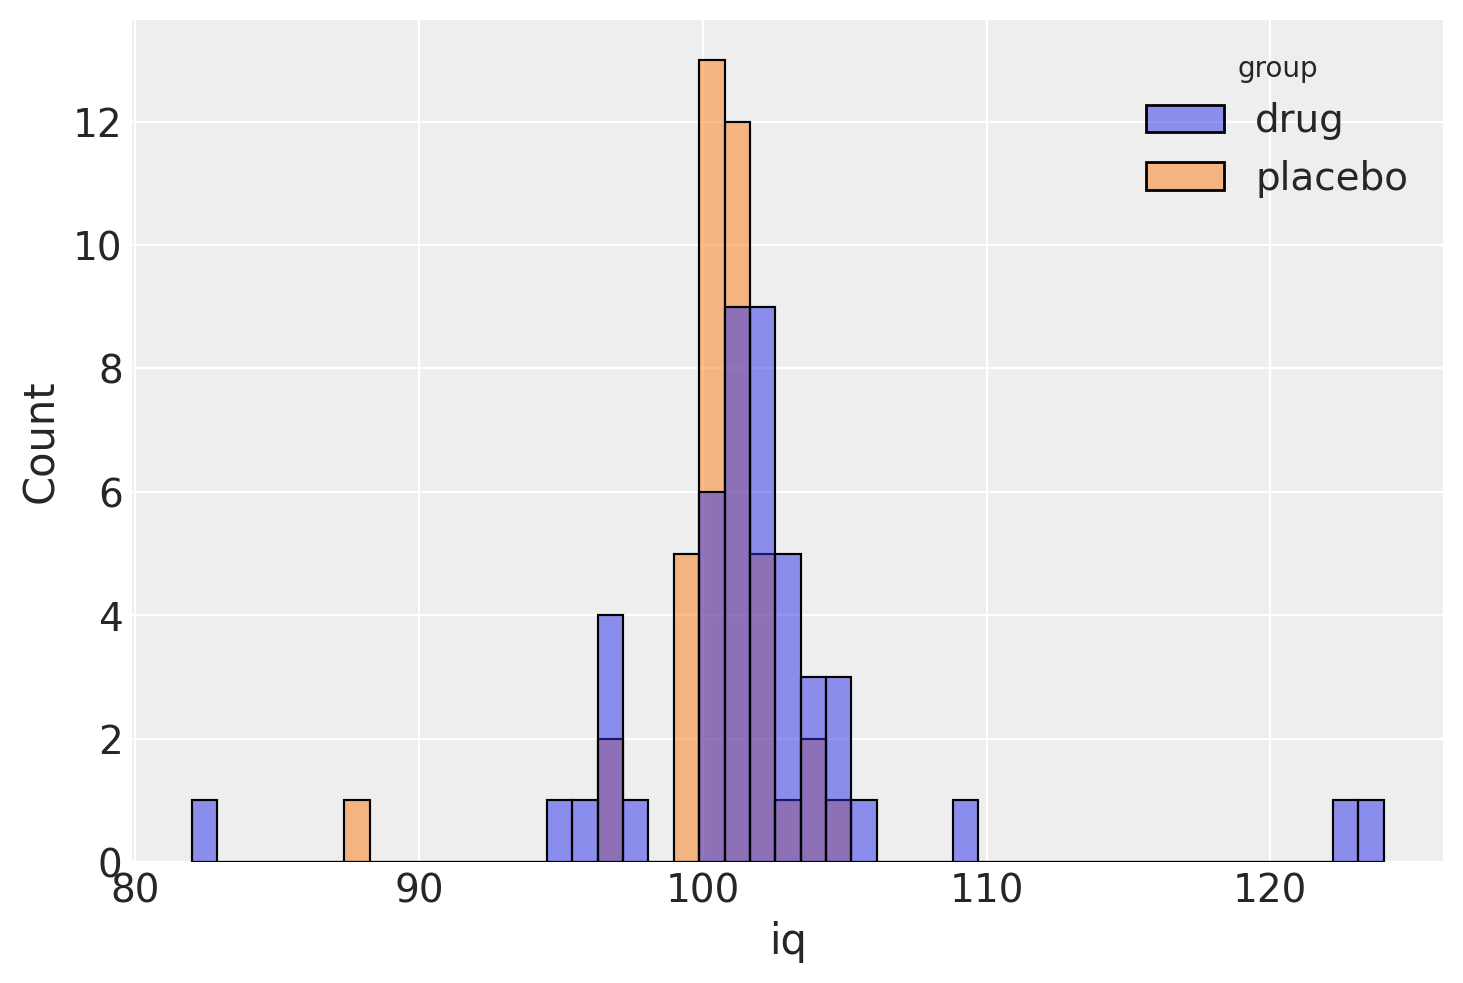

In [3]:
# fmt: off
iq_drug = np.array([
    101, 100, 102, 104, 102, 97, 105, 105, 98, 101, 100, 123, 105, 103, 
    100, 95, 102, 106, 109, 102, 82, 102, 100, 102, 102, 101, 102, 102,
    103, 103, 97, 97, 103, 101, 97, 104, 96, 103, 124, 101, 101, 100,
    101, 101, 104, 100, 101
])

iq_placebo = np.array([
    99, 101, 100, 101, 102, 100, 97, 101, 104, 101, 102, 102, 100, 105,
    88, 101, 100, 104, 100, 100, 100, 101, 102, 103, 97, 101, 101, 100,
    101, 99, 101, 100, 100, 101, 100, 99, 101, 100, 102, 99, 100, 99
])
# fmt: on

df1 = pd.DataFrame({"iq": iq_drug, "group": "drug"})
df2 = pd.DataFrame({"iq": iq_placebo, "group": "placebo"})
indv = pd.concat([df1, df2]).reset_index()

sns.histplot(data=indv, x="iq", hue="group");

In [6]:
sigma_low = 10**-1
sigma_high = 10

with pm.Model() as model:
    # "hiperparametros"
    mu_m = indv["iq"].mean()
    mu_s = indv["iq"].std() * 2

    # priors
    group1_mean = pm.Normal("group1_mean", mu=mu_m, sigma=mu_s)
    group2_mean = pm.Normal("group2_mean", mu=mu_m, sigma=mu_s)

    group1_std = pm.Uniform("group1_std", lower=sigma_low, upper=sigma_high)
    group2_std = pm.Uniform("group2_std", lower=sigma_low, upper=sigma_high)

    # nu, priorizando valores bajos
    nu_minus_one = pm.Exponential("nu_minus_one", 1 / 29.0)
    nu = pm.Deterministic("nu", nu_minus_one + 1) # para que cuente como variable
    nu_log10 = pm.Deterministic("nu_log10", np.log10(nu))

    # likelihood
    lambda_1 = group1_std**-2
    lambda_2 = group2_std**-2
    group1 = pm.StudentT("drug", nu=nu, mu=group1_mean, lam=lambda_1, observed=iq_drug)
    group2 = pm.StudentT("placebo", nu=nu, mu=group2_mean, lam=lambda_2, observed=iq_placebo)

    # difference
    diff_of_means = pm.Deterministic("difference of means", group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic("difference of stds", group1_std - group2_std)
    effect_size = pm.Deterministic(
        "effect size", diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2)
    )

In [7]:
import preliz as pz

<Axes: >

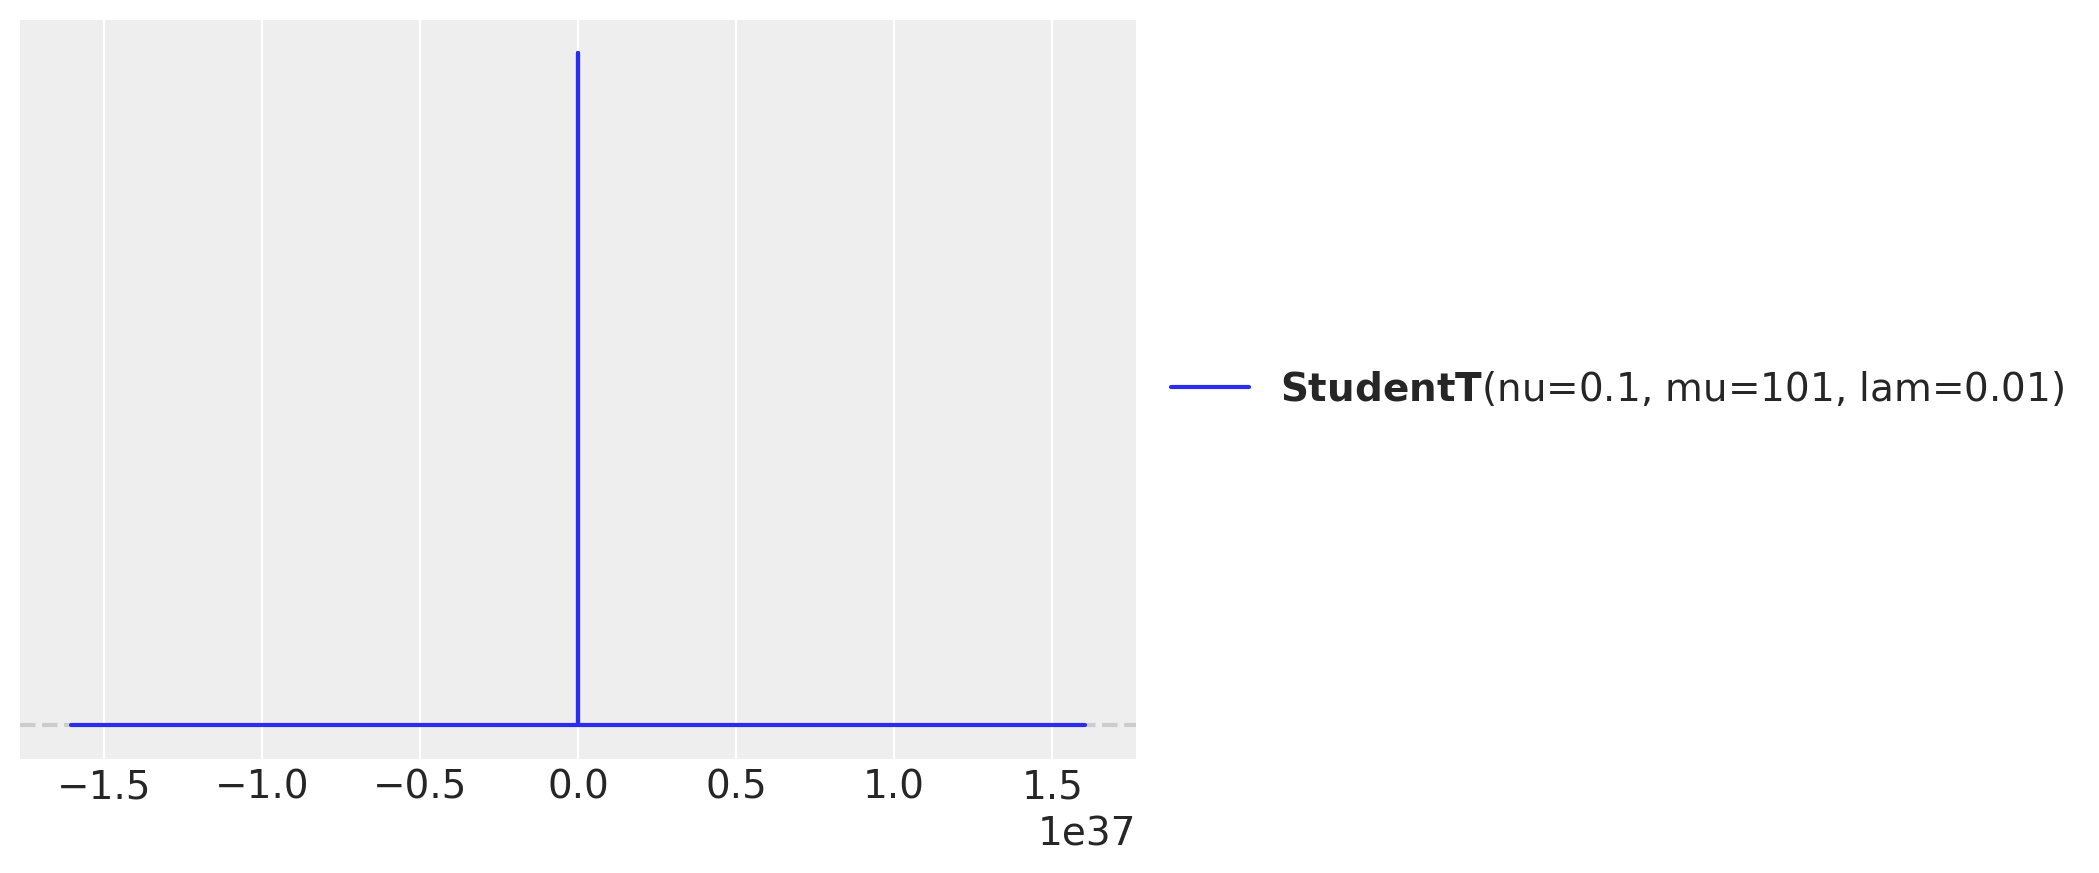

In [23]:
pz.StudentT(nu = 0.1, mu = mu_m, lam=10**-2).plot_pdf()